In [1]:
# visualizer_for_physics_model.py

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import random

from custom_visualizer import plot_trajectories, extract_player_trajectory, descale_trajectory


2025-05-02 04:02:14.760519: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# === 1. Load model ===
from Transformer_physics import build_model

model = build_model()
model.load_weights("../weights_physics/epoch_005.weights.h5")  # adjust to your best epoch
print("✅ Model loaded.")


✅ Model loaded.


In [6]:
# === 2. Load dataset ===
dataset_path = "processed_data/transformer_dataset"
raw_ds = tf.data.Dataset.load(dataset_path)

def filter_split(split_num):
    def _filter(meta, x, y):
        return tf.equal(meta[2], split_num)
    return _filter

def drop_meta(meta, x, y):
    return x, tf.concat([x[-1], y], axis=-1)

test_ds = (raw_ds
           .filter(filter_split(2))
           .map(drop_meta, num_parallel_calls=tf.data.AUTOTUNE)
           .batch(1)
           .prefetch(tf.data.AUTOTUNE))


In [12]:
# === 3. Pick one sample ===
X_batch, y_flat = next(iter(test_ds))  # shapes: (1, 100, 138), (1, 276)


In [13]:
# === 4. Rollout model prediction ===
n_steps = 10
context_len = X_batch.shape[1]

rollout = [X_batch[:, -1, :]]  # Start from t=100
cur_input = X_batch

for _ in range(n_steps):
    y_pred = model(cur_input)  # shape: (1, 69)
    pred_reshaped = tf.reshape(y_pred, (-1, 23, 3))

    # Extract position at t (x,y)
    last_frame = cur_input[:, -1, :]
    last_frame_reshaped = tf.reshape(last_frame, (-1, 23, 6))
    x_t_pos = last_frame_reshaped[:, :, :2]  # shape (1, 23, 2)
    s_true = last_frame_reshaped[:, :, 2]    # shape (1, 23)

    # Use physics to estimate next position
    a = pred_reshaped[:, :, 0]
    dir_sin = pred_reshaped[:, :, 1]
    dir_cos = pred_reshaped[:, :, 2]
    v_x = s_true * dir_cos + a * dir_cos * 0.1
    v_y = s_true * dir_sin + a * dir_sin * 0.1
    x_next = x_t_pos[:, :, 0] + v_x * 0.1
    y_next = x_t_pos[:, :, 1] + v_y * 0.1

    # Dummy filler for s,a,dir
    dummy = tf.zeros_like(x_next)
    next_frame = tf.stack([x_next, y_next, dummy, dummy, dummy, dummy], axis=-1)
    next_frame = tf.reshape(next_frame, (1, -1))  # shape (1, 138)

    rollout.append(next_frame)
    cur_input = tf.concat([cur_input[:, 1:], tf.expand_dims(next_frame, axis=1)], axis=1)
    

In [14]:
# === 5. Assemble full sequence ===
rollout_tensor = tf.concat(rollout, axis=0)  # shape (11, 138)
full_seq = tf.concat([X_batch[0], rollout_tensor[1:]], axis=0)  # (100 + n_steps, 138)


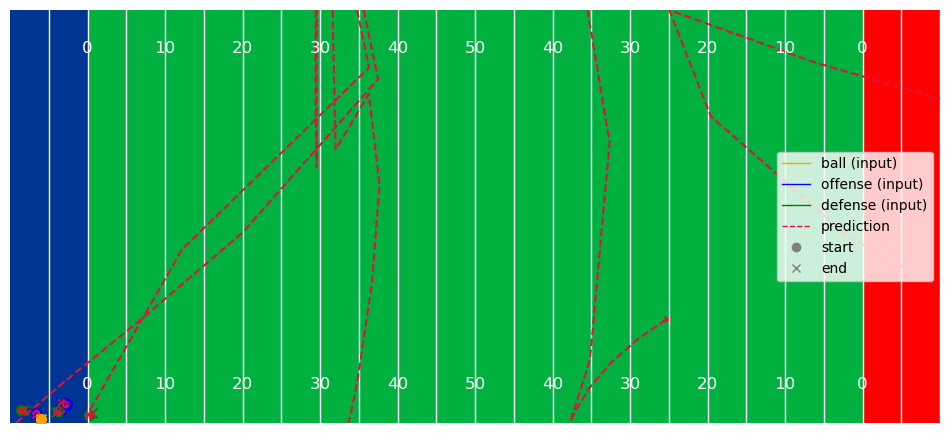

In [ ]:
# === 6. Visualize ===
_ = plot_trajectories(
        sequence=X_batch[0],
        pred_seq=full_seq,
        ground_truth_seq=None,  # we don't have gt here
        offense='all', defense='all', include_ball=True,
        gt_linestyle='-.', pred_linestyle='--',
        gt_color='limegreen', pred_color='crimson')

